In [1]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup as soup
import json

from tqdm import tqdm

import gender_guesser.detector as gender_detector
from unidecode import unidecode

from selenium import webdriver
path = r'C:\Users\tarek.vilela.CVER\Documents\chromedriver.exe'

import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (15, 8) 
plt.rcParams["figure.dpi"] = 300
plt.style.use('ggplot')

In [2]:
class TMDBApi:
    def __init__(self, api_key):
        self.api_key = api_key
        self.api_base = 'https://api.themoviedb.org/3/{}/{}?api_key={}'
        self.session = requests.Session()

    def request_from_api(self, url):
        r = self.session.get(url)

        if r.status_code == 200:
            return json.loads(r.content)
        else:
            print('Erro: ', r.status_code)

    def get_movie_from_id(self, movie_id, source='tmdb'):
        url = self.api_base.format('movie', movie_id, api_key)
        url += '&append_to_response=credits'

        if source == 'imdb':
            url += '&external_source=imdb_id'

        return self.request_from_api(url)

In [3]:
api_key = 'ed4a470893201136add7288368f820ac'
api = TMDBApi(api_key)

resp = api.get_movie_from_id('tt0018578', 'imdb')

In [24]:
pessoas = []
filmes = []
erros = []
years = tqdm(range(2021, 1928, -1))

for year in years:
    years.set_description(str(year))
    url = f'https://www.imdb.com/event/ev0000003/{year}/1/?ref_=ev_eh'
    r = requests.get(url)
    s = soup(r.content, 'html.parser')

    html = str(s.find_all('script')[37])
    n_start = html.find('{"awards"')
    n_end = html.find('requestKey') - 2
    data = json.loads(html[n_start:n_end] + '}')

    try:
        categorias = data['awards'][0]['categories']
        continuar = True

    except:
        continuar = False

    if continuar:
        for categoria in categorias:
            cat_name = categoria['categoryName']
            nominations = categoria['nominations']

            for nominee in nominations:
                try:
                    # verificar se eh pessoa ou filme 
                    if nominee['primaryNominees'][0]['const'][:2] == 'tt':
                        # é filme, então montar a base como tal
                        movie_name = nominee['primaryNominees'][0]['name']
                        movie_id = nominee['primaryNominees'][0]['const']
                        winner = 1 if nominee['isWinner'] else 0
                        filmes.append([year, cat_name, movie_name, movie_id, winner])
                        
                    elif nominee['primaryNominees'][0]['const'][:2] == 'nm':
                        # é pessoa
                        person_name = nominee['primaryNominees'][0]['name']
                        person_id = nominee['primaryNominees'][0]['const']
                        movie_name = nominee['secondaryNominees'][0]['name']
                        movie_id = nominee['secondaryNominees'][0]['const']
                        winner = 1 if nominee['isWinner'] else 0
                        pessoas.append([year, cat_name, person_name, person_id, movie_name, movie_id, winner])
            
                    else:
                        erros.append([year, cat_name])
                
                except:
                    erros.append([year, cat_name])

1929: 100%|██████████| 93/93 [01:35<00:00,  1.03s/it]


In [26]:
filmes_df = pd.DataFrame(filmes)
filmes_df.columns = ['Ano', 'Categoria', 'Filme', 'movie_id', 'Venceu']
filmes_df.to_excel('filme_df.xlsx', index=False)

pessoas_df = pd.DataFrame(pessoas)
pessoas_df.columns = ['Ano', 'Categoria', 'Nome', 'person_id', 'Filme', 'movie_id', 'Venceu']
pessoas_df.to_excel('pessoas_df.xlsx', index=False)

In [5]:
filmes_df = pd.read_excel('filme_df.xlsx')
pessoas_df = pd.read_excel('pessoas_df.xlsx')

In [6]:
best_picture_list = filmes_df.query('Categoria in ["Best Motion Picture of the Year", "Best Picture", "Best Picture, Production"]').copy()
best_picture_list.to_excel('best_pic.xlsx')

In [9]:
def _get_gender(row):

    def _guess_gender(decode=False):
        name = row['name'].split(' ')[0]
        if decode:
            name = unidecode(name)
        
        if isinstance(row['character'], float):
            character_name = name
        
        else:
            character_name = row['character']
            if decode:
                character_name = unidecode(character_name)

        guessed_gender = d.get_gender(name)

        if guessed_gender == 'female':
            return 1
        
        elif guessed_gender == 'male':
            return 2

        elif guessed_gender in ['mostly_female', 'andy']:
            char_guess = d.get_gender(character_name)

            if char_guess in ['female', 'mostly_female']:
                return 1

            else:
                return 0

        elif guessed_gender in ['mostly_male', 'andy']:
            char_guess = d.get_gender(character_name)

            if char_guess in ['male', 'mostly_male']:
                return 2

            else:
                return 0

        elif guessed_gender == 'unknown':
            char_guess = d.get_gender(character_name)

            if char_guess in ['female', 'mostly_female']:
                return 1

            elif char_guess in ['male', 'mostly_male']:
                return 2

            else:
                return 0

    # 1: mulher, 0: homem
    dict_ = {1: 1, 2: 0}

    if row['gender'] in [1, 2]:
        return dict_[row['gender']]

    else:
        guessed = _guess_gender()
        if guessed > 0:
            return dict_[guessed]
        
        else:
            guessed = _guess_gender(decode=True)
            
            if guessed > 0:
                return dict_[guessed]

            else:
                return np.nan

In [10]:
movies_database = pd.DataFrame()
cast_crew_database = pd.DataFrame()

#driver = webdriver.Chrome(path)
d = gender_detector.Detector()

iterator = tqdm(range(best_picture_list.shape[0]))

erros = []
for r in iterator:
    row = best_picture_list.iloc[r].copy()
    cat_name = row['Categoria']
    movie_name = row['Filme']
    year = row['Ano']
    won = row['Venceu']
    movie_id = row['movie_id']

    resp = api.get_movie_from_id(movie_id, 'imdb')

    res_movie = [[i[0], i[1]] for i in zip(resp.keys(), resp.values())] + \
                [[i['name'], 1] for i in resp['genres']] + \
                [['cat_name', cat_name], ['year', year], ['won', won]]

    res_movie = pd.DataFrame(res_movie)
    res_movie['movie_id'] = movie_id

    cast = pd.DataFrame(resp['credits']['cast'])
    crew = pd.DataFrame(resp['credits']['crew'])

    cast_crew = pd.concat([cast, crew], axis=0).drop_duplicates('id')
    
    cast_crew['guessed_gender'] = cast_crew.apply(_get_gender, axis=1)
    cast_crew['movie_id'] = movie_id

    movies_database = pd.concat([movies_database, res_movie], axis=0)
    cast_crew_database = pd.concat([cast_crew_database, cast_crew], axis=0)

100%|██████████| 566/566 [02:48<00:00,  3.37it/s]


In [11]:
cast_crew_database['guessed_gender'] = cast_crew_database.apply(_get_gender, axis=1)
cast_crew_database['cast_crew'] = cast_crew_database['cast_id'].apply(lambda x: 'cast' if not np.isnan(x) else 'crew')
movies_database_ = movies_database.pivot(columns=0, values=1, index='movie_id').fillna(0)
cast_crew_database_ = cast_crew_database.merge(movies_database_.reset_index()[['year', 'movie_id']], on='movie_id', how='left').copy()

In [18]:
movies_database_.to_excel('filmes_base_pronta.xlsx')
cast_crew_database_.to_excel('pessoas_base_pronta.xlsx')

In [28]:
cast_crew_database_.shape

(52299, 18)

In [29]:
pd.merge(cast_crew_database_, movies_database_[['cat_name', 'original_title', 'year', 'won']].reset_index(), on='movie_id', how='left').shape

(52299, 22)

In [27]:
cast_crew_database_ = pd.merge(cast_crew_database_, movies_database_[['cat_name', 'original_title', 'year', 'won']].reset_index(), on='movie_id', how='left').to_excel('pessoas_base_pronta.xlsx')

In [12]:
cast_crew_database_.groupby(['year']).mean()

,adult,gender,id,popularity,cast_id,order,guessed_gender
year,,,,,,,
1929,0.000000,1.282353,6.398342e+05,0.860459,22.159091,6.954545,0.234568
1930,0.000000,1.265734,6.423751e+05,0.961769,22.526882,13.086022,0.291971
1931,0.000000,1.429688,4.771046e+05,0.955484,19.324675,9.025974,0.178862
1932,0.000000,1.606635,3.496677e+05,1.033583,16.268908,8.008403,0.205742
1934,0.000000,1.479899,4.033857e+05,0.924269,20.876652,13.334802,0.209719
...,...,...,...,...,...,...,...
2017,0.000597,0.666069,1.368792e+06,0.908610,99.533333,34.546237,0.309103
2018,0.000000,0.688392,1.453981e+06,0.948320,69.295739,25.832080,0.314971
2019,0.002175,0.637418,1.526631e+06,1.014693,75.855643,27.220472,0.293564


In [13]:
movies_database_['original_language'].unique()

array(['en', 'fr', 'el', 'sv', 'it', 'zh', 'es', 'ko'], dtype=object)

In [14]:
movies_database_.groupby('original_language').count()

,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,History,Horror,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,won,year
original_language,,,,,,,,,,,,,,,,,,,,,
el,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
en,555,555,555,555,555,555,555,555,555,555,...,555,555,555,555,555,555,555,555,555,555
es,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
fr,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
it,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
ko,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
sv,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
zh,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Text(0.5, 1.0, 'Proporção de mulheres')

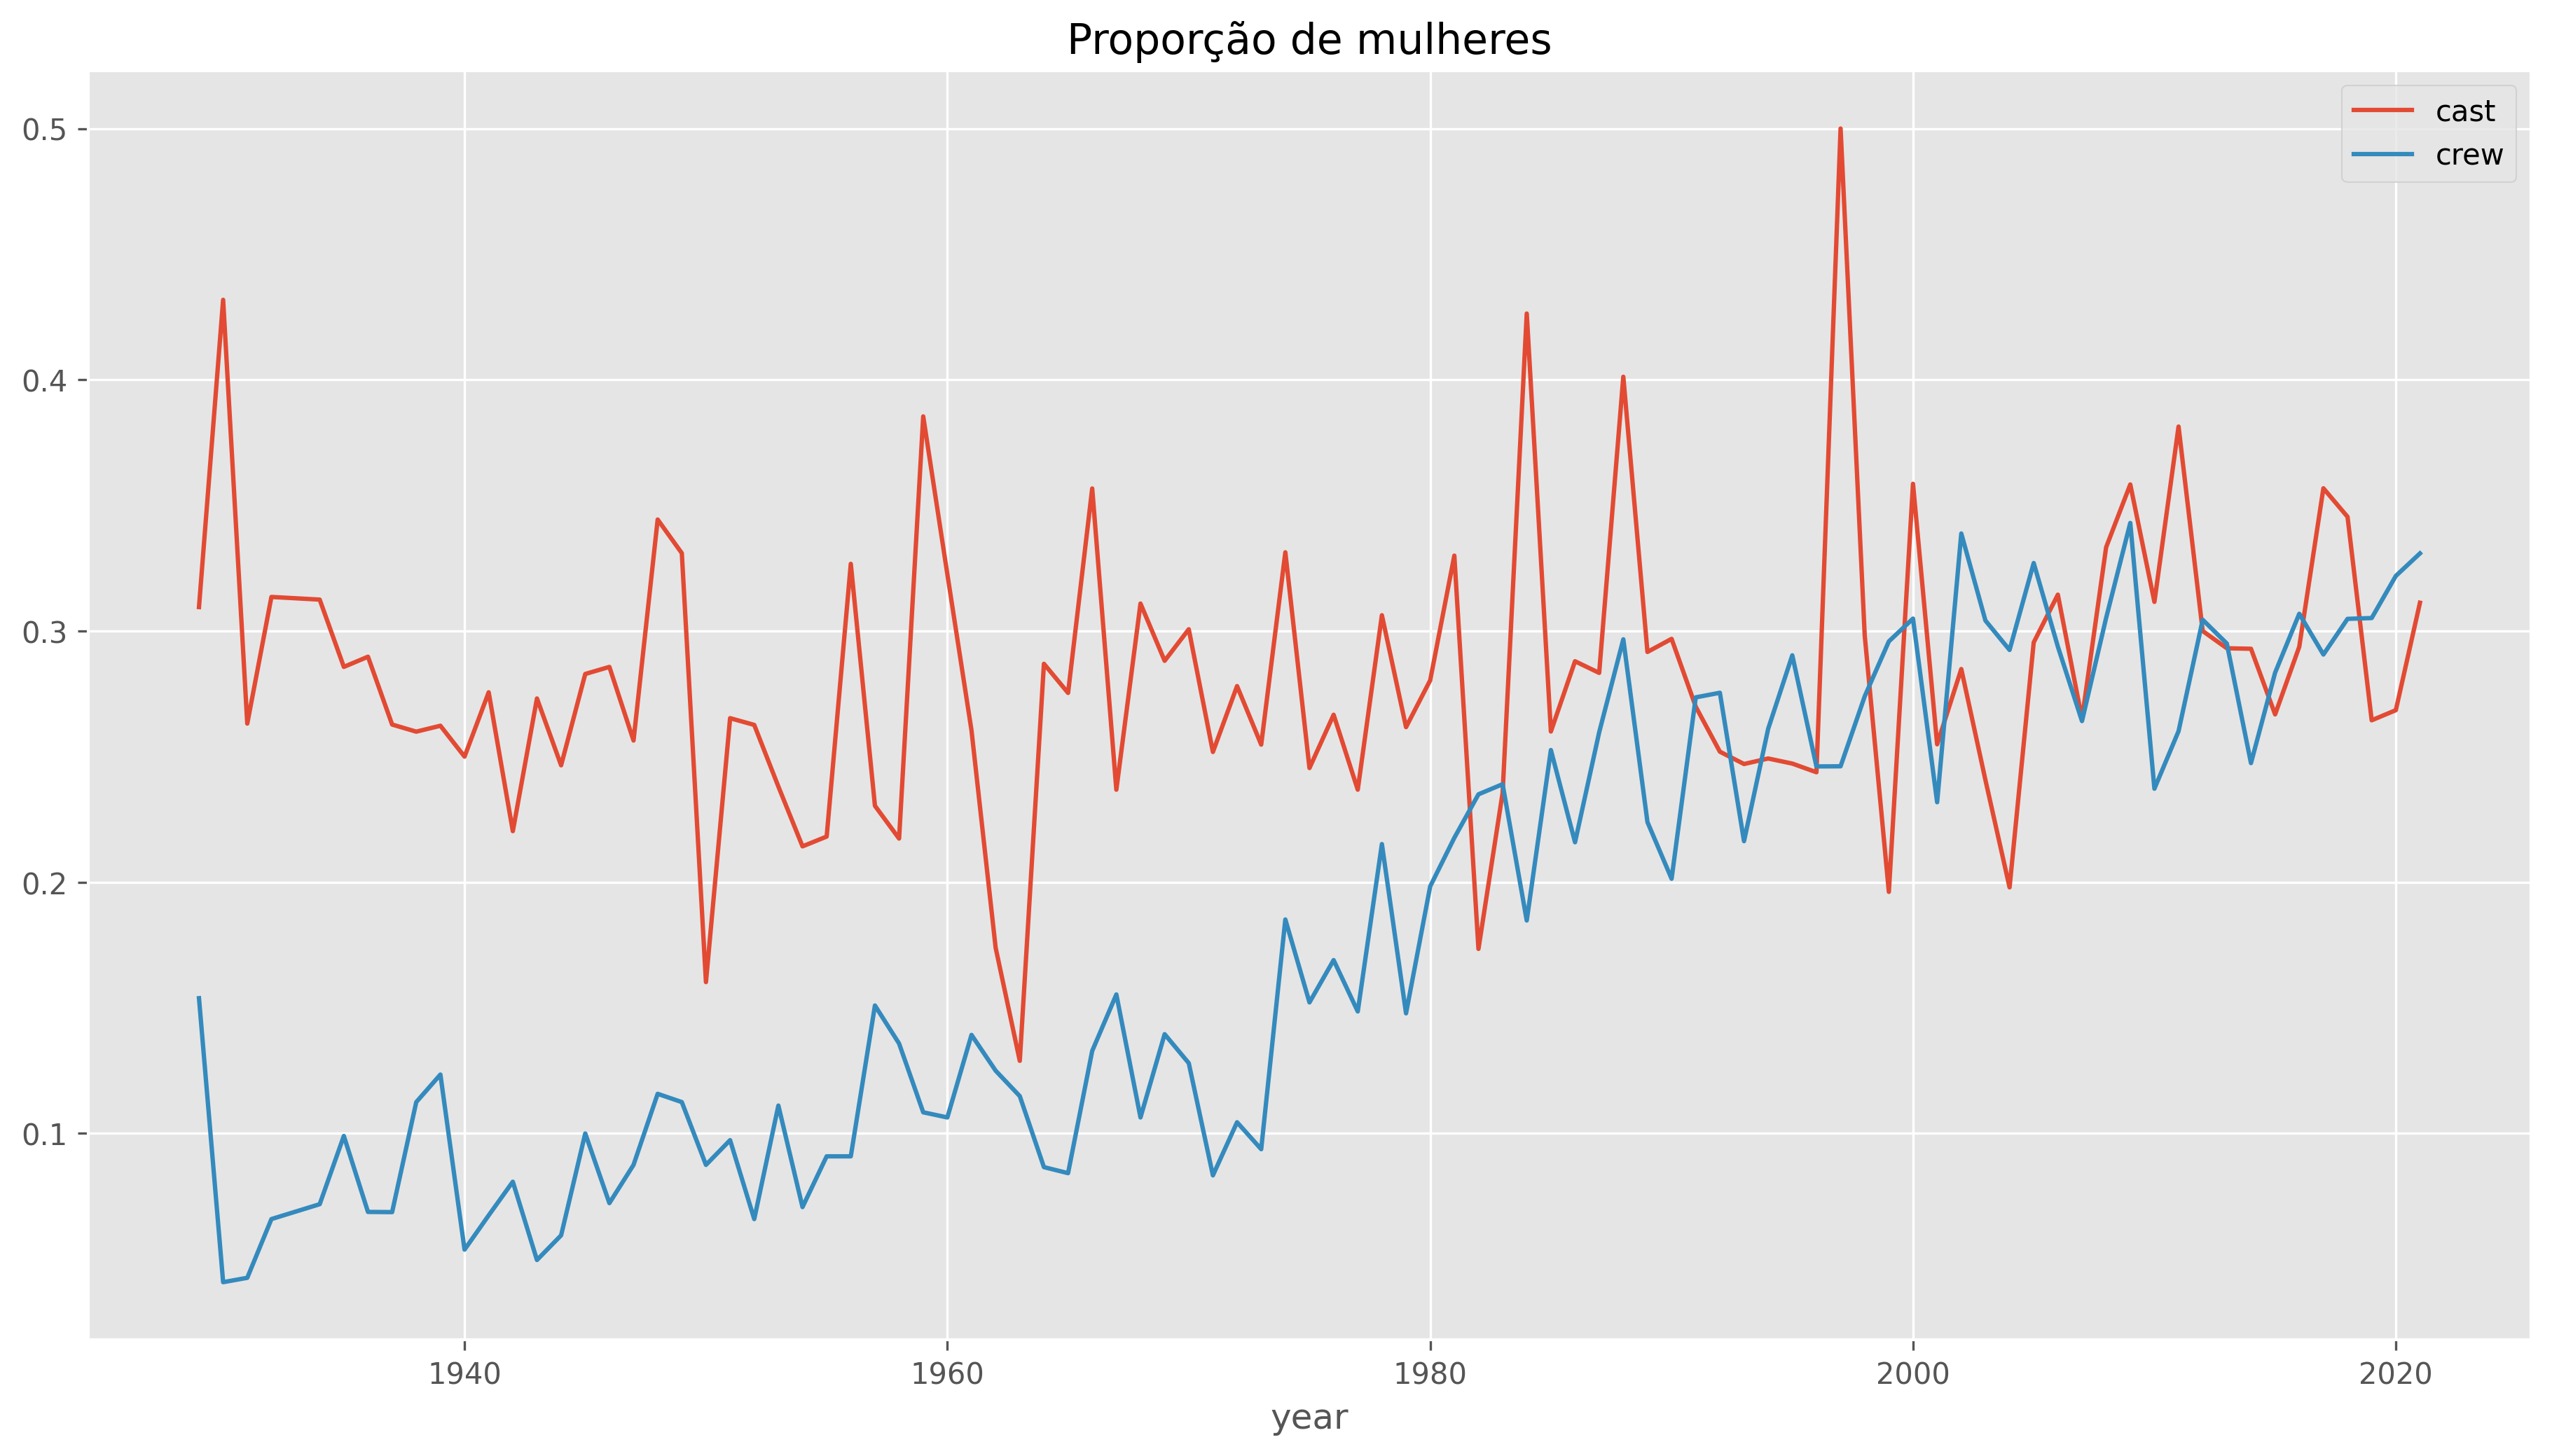

In [15]:
cast_crew_database_.groupby(['cast_crew', 'year']).mean().loc['cast']['guessed_gender'].plot(label='cast', legend=True)
cast_crew_database_.groupby(['cast_crew', 'year']).mean().loc['crew']['guessed_gender'].plot(label='crew', legend=True)
plt.title('Proporção de mulheres')

In [276]:
genres = set([movies_database[movies_database[0]=='genres'][1].iloc[i][j]['name'] 
                for i in range(movies_database[movies_database[0]=='genres'][1].shape[0]) 
                for j in range(len(movies_database[movies_database[0]=='genres'][1].iloc[i]))])

In [290]:
movies_database_[genres].mean()

0
Western            0.037102
Music              0.072438
Crime              0.109541
History            0.157244
War                0.116608
Romance            0.344523
Horror             0.008834
Thriller           0.118375
Adventure          0.088339
Science Fiction    0.024735
Family             0.049470
Mystery            0.053004
Fantasy            0.045936
Action             0.081272
Animation          0.005300
Comedy             0.210247
Drama              0.839223
dtype: float64

In [345]:
from statsmodels.discrete.discrete_model import Logit

In [347]:
movies_database_.columns

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'Thriller', 'War', 'Western', 'adult',
       'backdrop_path', 'belongs_to_collection', 'budget', 'cat_name',
       'credits', 'genres', 'homepage', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'won', 'year'],
      dtype='object', name=0)

In [369]:
movies_database_[list(genres)].sum()

0
Western             21
Music               41
Crime               62
History             89
War                 66
Romance            195
Horror               5
Thriller            67
Adventure           50
Science Fiction     14
Family              28
Mystery             30
Fantasy             26
Action              46
Animation            3
Comedy             119
Drama              475
dtype: int64

In [482]:
movies_database_.columns

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'Thriller', 'War', 'Western', 'adult',
       'backdrop_path', 'belongs_to_collection', 'budget', 'cat_name',
       'credits', 'genres', 'homepage', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'won', 'year', 'pred'],
      dtype='object', name=0)

In [379]:
genres_ = list(genres)
del genres_[genres_.index('Horror')]
del genres_[genres_.index('Animation')]
del genres_[genres_.index('Science Fiction')]

In [486]:
X = movies_database_[genres_ + ['vote_average', 'vote_count', 'runtime', 'budget', 'revenue']].copy()

In [487]:
m = Logit(movies_database_['won'], X).fit()

Optimization terminated successfully.
         Current function value: 0.415780
         Iterations 7


In [488]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    won   No. Observations:                  566
Model:                          Logit   Df Residuals:                      547
Method:                           MLE   Df Model:                           18
Date:                Mon, 14 Jun 2021   Pseudo R-squ.:                 0.06327
Time:                        14:33:49   Log-Likelihood:                -235.33
converged:                       True   LL-Null:                       -251.23
Covariance Type:            nonrobust   LLR p-value:                   0.02327
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Western         -0.1746      0.680     -0.257      0.797      -1.507       1.158
Music            0.1564      0.434      0.360      0.719      -0.694       1.007
Crime            0.2631      0.425      0.620      0.535      -0.569       1.095
History          0.0695      0.348      0.200      0.842      -0.613       0.751
War              0.1153      0.361      0.319      0.750      -0.593       0.824
Romance         -0.0784      0.271     -0.290      0.772      -0.609       0.452
Thriller        -0.1303      0.429     -0.304      0.761      -0.971       0.710
Adventure       -0.3932      0.519     -0.757      0.449      -1.411       0.625
Family           0.0121      0.611      0.020      0.984      -1.186       1.210
Mystery         -0.8621      0.797     -1.082      0.279      -2.423       0.699
Fantasy         -0.8870      0.764     -1.161      0.246      -2.384       0.610
Action           0.0298      0.491      0.061      0.952      -0.934       0.993
Comedy           0.0851      0.323      0.264      0.792      -0.547       0.717
Drama            0.3907      0.417      0.938      0.348      -0.426       1.207
vote_average    -0.5861      0.105     -5.592      0.000      -0.791      -0.381
vote_count       0.0001   3.93e-05      3.139      0.002    4.63e-05       0.000
runtime          0.0173      0.005      3.383      0.001       0.007       0.027
budget       -3.099e-08   8.35e-09     -3.710      0.000   -4.74e-08   -1.46e-08
revenue       2.486e-09   9.14e-10      2.720      0.007    6.94e-10    4.28e-09
================================================================================
"""

In [489]:
movies_database_['pred'] = m.predict(X.values)

In [490]:
movies_database_['pred'] = (movies_database_.reset_index().set_index('year')['pred'] / movies_database_.groupby('year').mean()['pred']).values

In [493]:
x = movies_database_.set_index('year')

In [494]:
acertos = []
for year in years:
    try:
        won = x.loc[year].sort_values('pred', ascending=False).iloc[0]['won']
        if won:
            acertos.append(year)

    except:
        pass